In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
plt.style.use('ggplot')
import gc
import warnings as w
w.filterwarnings('ignore')

## EVCF(Enhancing VAEs for collaborative Filtering)
### Github Link : https://github.com/psywaves/EVCF

In [3]:
df = pd.read_csv('../input/netflix-prize-data/combined_data_1.txt',
                   low_memory=True,header=None,names=['Cust_id','Rating'],usecols=[0,1])
df

,Cust_id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


4.0    0.336153
3.0    0.287031
5.0    0.228928
2.0    0.101401
1.0    0.046487
Name: Rating, dtype: float64


131

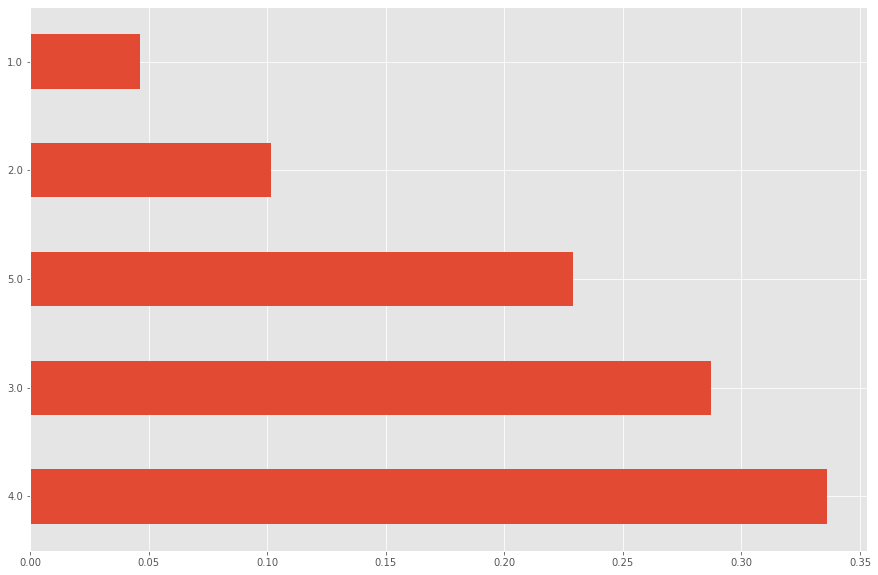

In [4]:
df.Rating.value_counts(normalize=True).plot.barh(figsize=(15,10))
print(df.Rating.value_counts(normalize=True))
gc.collect()

In [4]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1


last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [6]:
df

,Cust_id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [7]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_id'] = df['Cust_id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
          Cust_id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


In [22]:
df = df[['Cust_id', 'Movie_Id', 'Rating']]
df.columns = ['userId', 'movieId', 'rating']
df.head()

,userId,movieId,rating
1,1488844,1,3.0
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
5,823519,1,3.0


In [26]:
df = df[df.rating > 3.5]

In [91]:
df

,userId,movieId,rating
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
7,124105,1,4.0
9,1842128,1,4.0
...,...,...,...
24058249,2092745,4499,5.0
24058250,555962,4499,5.0
24058253,272857,4499,4.0
24058257,2562830,4499,4.0


In [92]:
raw_data = df
raw_data.head()

,userId,movieId,rating
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
7,124105,1,4.0
9,1842128,1,4.0


In [98]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id)
    count = playcount_groupbyid.size()
    return count

In [99]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        print(itemcount)
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        print(usercount)
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [100]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)

userId
6           61
7          142
8           17
10          23
25           2
          ... 
2649404      9
2649409      9
2649421      3
2649426     64
2649429     49
Length: 458436, dtype: int64


In [103]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 13356512 watching events from 359977 users and 4498 movies (sparsity: 0.825%)


In [106]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [107]:
n_users = unique_uid.size
n_heldout_users = 40000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [108]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]


In [110]:
unique_sid = pd.unique(train_plays['movieId'])

In [111]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [114]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [117]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled


In [118]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled


In [123]:
test_plays_tr

,userId,movieId,rating
789231,10,191,4.0
876574,10,197,4.0
2582672,10,473,5.0
4922407,10,985,5.0
7686047,10,1542,5.0
...,...,...,...
18982777,2649429,3624,5.0
19313117,2649429,3670,5.0
22760116,2649429,4306,5.0
23215056,2649429,4356,4.0


In [122]:
test_plays_te

,userId,movieId,rating
3127303,10,571,4.0
16088964,10,3124,5.0
16757751,10,3254,4.0
21530944,10,4043,5.0
7008741,94,1406,5.0
...,...,...,...
16894536,2649429,3275,5.0
18070834,2649429,3434,4.0
18236190,2649429,3466,4.0
20804463,2649429,3925,5.0


In [129]:
with open(os.path.join('unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [125]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])
train_data = numerize(train_plays)
train_data.to_csv(os.path.join( 'train.csv'), index=False)
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join('validation_tr.csv'), index=False)
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join('validation_te.csv'), index=False)
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join('test_tr.csv'), index=False)
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join( 'test_te.csv'), index=False)

## Model & train_session : https://www.kaggle.com/code/leejunseok97/evcf-sota-model-rc?scriptVersionId=97638893